# Geomagnetic Conjugate Map
The purpose of this notebook is to gather relevant stations and mapping information for a geomagnetic conjugate map, from Lanzerotti 1987:

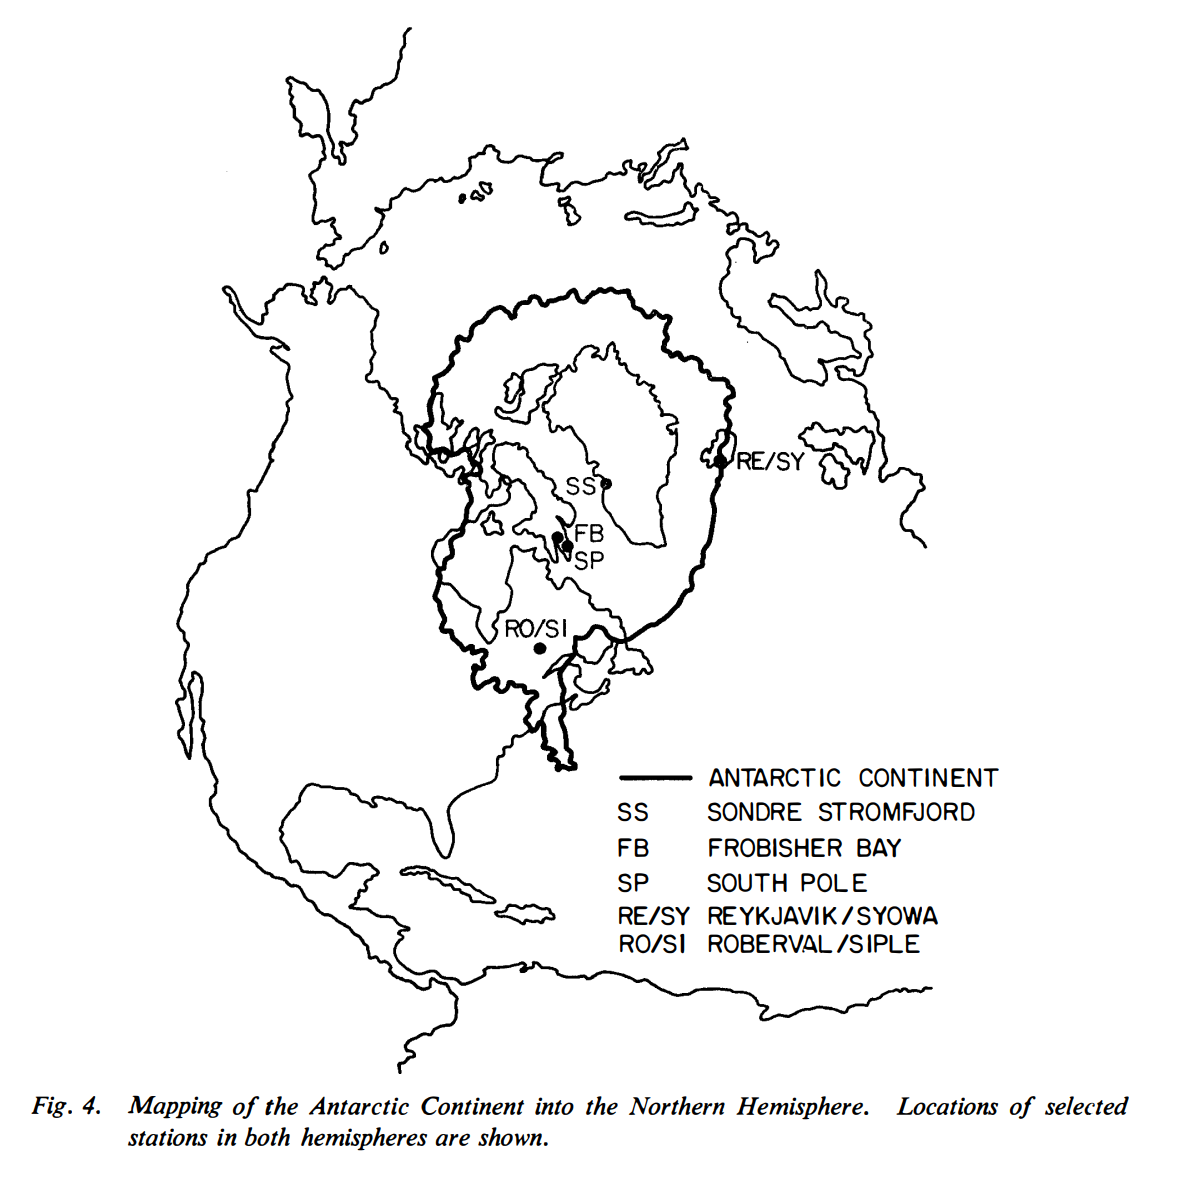

Papers on field line tracing: 
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008SW000391
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgra.50137
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JA020264

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
import ogr
import geopandas as gpd
import aacgmv2
import datetime as dt
import numpy as np
import os
import plotly.graph_objects as go

# smag = __import__('supermag-api')          # SuperMAG python API
# logon = 'kd8oxt'                              # SuperMAG ID

# # For pulling data from CDAweb:
# from ai import cdas
# import datetime
# from matplotlib import pyplot as plt

import gpxpy
import gpxpy.gpx

import geopandas

# converting from geographic to GSM
from geopack import geopack as gp 
from geopack import t89

# Import functions:
import datetime
from conjCalcFunctions import *

The following functions are imported from `conjCalcFunctions.py`:
 - `findconj()` : function to compute conjugate points for a given location at a given time and date. 
 - `conjcalc()` : function to take in a dataframe and add columns for all stages of calculating conjugate points.
 - `calc_mlat_rings()` : function to calculate magnetic graticules for a given latitude and datetime.

In [ ]:
help(calc_mlat_rings)

In [ ]:
ut = dt.datetime(1980, 11, 3, 18, 0, 0)
lat, lon = [-64, -64]

print("Geopack: ")
print(findconj(lat, lon, ut, method="geopack"))
print("AACGM: ")
print(findconj(lat, lon, ut, method="aacgm"))

## Stations and Features
First, let's collect stations and features of interest into pandas dataframes. (Make sure to include dates of operation wherever possible - want to make sure that we have that information when creating historical maps later!)

I'm collecting station information here: https://docs.google.com/spreadsheets/d/1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8/edit?usp=sharing

A version of this is also included in the `\input` folder.

In [ ]:
import pandas as pd
stations = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8'+
                   # '/edit#gid=0'
                   # '0Ak1ecr7i0wotdGJmTURJRnZLYlV3M2daNTRubTdwTXc' +
                   '/export?gid=0&format=csv',
                   # Set first column as rownames in data frame
                   index_col=0,
                   # Parse column values to datetime
                   parse_dates=['Start', 'End']
                  )
# Comment in this line instead of the line above to use the local copy:
# stations = pd.read_csv('input/PGC Conjugate Map Points.csv',
#                    # Set first column as rownames in data frame
#                    index_col=0,
#                    # Parse column values to datetime
#                    parse_dates=['Start', 'End']
#                   )
stations["Source"] = "Manual"
stations.head() 

### Northern Hemisphere Stations
- [ ] All-sky cameras
- [X] Full set of magnetometer networks from SuperMAG

Let's pull some more Northern hemisphere stations from the list of instruments in the Madrigal database, at http://cedar.openmadrigal.org/instMetadata. (It would be good form to use the `madrigalWeb` python package for this if we need more data.)

In [ ]:
# madrigal = pd.read_csv("madrigal.csv")
madrigal = pd.read_html("http://cedar.openmadrigal.org/instMetadata")[0]
madrigal = madrigal.rename(columns={"3-letter mnemonic": "ID", "Latitude": "GLAT", "Longitude (-180-180)":"GLON"})
madrigal = madrigal.set_index("Name")
madrigal["Source"] = "Madrigal"

# add to stations list:
stations = pd.concat([stations, madrigal], ignore_index=False)

Downloading SUPERMAG's list of stations from https://supermag.jhuapl.edu/mag/?fidelity=low&tab=stationinfo&start=2001-01-01T00%3A00%3A00.000Z&interval=23%3A59#:

(I've edited the operators column of the spreadsheet to make it digestible to pandas...)

In [ ]:
supermag = pd.read_csv("20230803-11-15-supermag-stations.csv", sep = ',') 

supermag = supermag.rename(columns={"STATION-NAME":"Name", "IAGA": "ID", "GEOLAT": "GLAT", "GEOLON":"GLON", "OP1":"Network"})
supermag = supermag.set_index("Name")
supermag["Category"] = "Magnetometers"
supermag["Source"] = "SuperMAG"

# add to stations list:
stations = pd.concat([stations, supermag], ignore_index=False)

Alternatively, we can pull data using the SuperMAG API:

### Antarctic Stations
We'll import COMNAP data from https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/tree/master

In [ ]:
url = "https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/raw/master/dist/COMNAP_Antarctic_Facilities_Master.xls"

comnap_df = pd.read_excel(url)

comnap = comnap_df.rename(columns={"English Name":"Name", "Type": "Category", "Latitude (DD)": "GLAT", "Longitude (DD)":"GLON", "Operator (primary)":"Nation"})
comnap = comnap.set_index("Name")
comnap["Source"] = "COMNAP"

# add to stations list:
stations = pd.concat([stations, comnap], ignore_index=False)

# stations

In [ ]:
import plotly.express as px
fig = px.scatter_geo(comnap_df,
                    lat=comnap_df["Latitude (DD)"],
                    lon=comnap_df["Longitude (DD)"],
                    hover_name="English Name",
                    color = "Type")
fig.update_geos(projection_type="orthographic")
fig.show()

## Finalizing station table
Before we start doing coordinate transforms, let's drop stations that have NaN longitude values and aggregate entries to the extent we can. 
This next line reduces the large station table to a fairly representative set of test values - it can be commmented in for testing purposes, or out to create the full table.

In [ ]:
# stations = stations.loc[['PG0', 'PG1', 'PG2', 'PG3', 'PG4', 'PG5', 'Vernadsky', 'South Pole Station', 'Syowa', 'Palmer', 'McMurdo', 'Cape Disappointment', 'South Pole Station', 'Bor', 'Clyde River']]
stations

We can filter out the stations from a single network if we like:

In [ ]:
stations[stations.Network=="AALPIP"]
pd.unique(stations.Institution)
# stations[stations.Institution=="BAS"]

### Eclipse Paths
Shunrong Zhang computed paths at various elevations for relevant eclipses. These can be found in the `/input` file.

Code to convert all the eclipse paths to .gpx files (only needed to run this once. Run `pip install gpxpy` if you need to rerun it).

## Maps

Let's begin by plotting all the points on a globe map using plotly express.

In [ ]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["GLAT"],
                    lon=stations["GLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Category")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/all-stations.html")

### Antarctic Coastline

In [ ]:
gdf = geopandas.read_file("stanford-yk702xd7587-geojson.json")
gdf.geometry

# df.geometry[0].exterior

points = []
for polygon in gdf.geometry[0]:
    for point in polygon.exterior.coords:
        points.append({"lat": point[1], "lon": point[0]})
Antarctic_coastline = pd.DataFrame(points)

with open('stanford-yk702xd7587-geojson.json') as f:
  Antarctic_coast = json.load(f)

We can visualize the geometry of the coastline directly in Jupyter notebook. Yep, looks like Antarctica:

In [ ]:
gdf.geometry[0]

Let's compute the conjugate points for this outline, then export them as a .gpx file. That shape is *huge*, so let's  reduce the resolution so it's easier to run computations on.

In [ ]:
# foo = conjcalc(Antarctic_coastline.sample(20000).sort_index(), latname = 'lat', lonname='lon')
foo = conjcalc(Antarctic_coastline.sample(10000).sort_values('lon'), latname = 'lat', lonname='lon')
# foo = conjcalc(Antarctic_coastline.sample(10000).sort_values('lon'), latname = 'lat', lonname='lon')

df = foo[['PLAT', 'PLON']]

gpx = gpxpy.gpx.GPX()

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:
for idx in df.index:
    gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(df.loc[idx, 'PLAT'], df.loc[idx, 'PLON']))

# print(gpx.to_xml())

with open('output/conj-Ant.gpx', 'w') as f:
    f.write(gpx.to_xml())


In [ ]:
ant=foo.copy()
ant

fig = px.scatter_geo(ant,
                    lat=ant["PLAT"],
                    lon=ant["PLON"],
                    # hover_name="Name",
                    # hover_data=["Hemisphere"],
                    hover_data = ["PLAT", "PLON"],
                    )
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/AntarcticConjugate.html")

### Coordinate Conversions
Now to run the conversions and save the results as .CSV files:

In [ ]:
n2s = conjcalc(stations, dtime = dt.datetime(2020, 1, 1), mode = 'N2S', method = 'aacgm', is_saved = True)
n2s.to_csv('output/stations_N2S_aacgm.csv') #save as .csv
s2n = conjcalc(stations, dtime = dt.datetime(2020, 1, 1), mode = 'S2N', method = 'aacgm', is_saved = True)
s2n.to_csv('output/stations_S2N_aacgm.csv') #save as .csv
# conjcalc(stations)
# stations[stations.index=="PG0"].GLON


stations = conjcalc(stations, is_saved = True)
# stations.to_csv('output/stations.csv') #save as .csv

And map:

In [ ]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["PLAT"],
                    lon=stations["PLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Hemisphere",
                    symbol = 'Network'
                    )
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/conj-stations.html")

As a sanity check, let's look at just the conjugate points for southern stations, color-coded by source.

In [ ]:
fig = px.scatter_geo(stations[stations['Hemisphere']=='S'].reset_index(),
                    lat=stations[stations['Hemisphere']=='S']["PLAT"],
                    lon=stations[stations['Hemisphere']=='S']["PLON"],
                    hover_name="Name",
                    # hover_data=["Hemisphere"],
                    hover_data = ["GLAT", "GLON"],
                    # color = "Source",
                     color = 'Hemisphere',
                    symbol = 'Network'
                    )#stations["GLAT"])
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/conj-stations-south.html")

## Compare `aacgm` vs `geopack`
Let's see how much difference there is in the results between these two approaches.

In [ ]:
# run conjcalc for aacgm
foo = conjcalc(stations, method = "aacgm", mode = 'flip')
foo['PLAT_aacgm'] = foo['PLAT']
foo['PLON_aacgm'] = foo['PLON']
# run conjcalc with geopack
foo = conjcalc(stations, method = "geopack", mode = 'flip')
foo = foo.rename(columns={"PLAT": "PLAT_geopack", "PLON": "PLON_geopack"})

# flight path chart
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    # locationmode = 'USA-states',
    lon = foo['PLON_aacgm'],
    lat = foo['PLAT_aacgm'],
    hoverinfo = 'text',
    text = foo['ID'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.add_trace(go.Scattergeo(
    # locationmode = 'USA-states',
    lon = foo['PLON_geopack'],
    lat = foo['PLAT_geopack'],
    hoverinfo = 'name',
    text = foo['ID'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(0, 255, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

flight_paths = []
for i in range(len(foo)):
    fig.add_trace(
        go.Scattergeo(
            # locationmode = 'USA-states',
            lon = [foo['PLON_aacgm'][i], foo['PLON_geopack'][i]],
            lat = [foo['PLAT_aacgm'][i], foo['PLAT_geopack'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            # opacity = float(foo['cnt'][i]) / float(foo['cnt'].max()),
        )
    )

fig.update_layout( 
    title_text = 'AACGM vs geopack',
    showlegend = False,
    geo = dict(
        # scope = 'north america',
        projection_type = 'orthographic',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

## Graticules
It can be useful to visualize magnetic latitude over time. 

In [ ]:
rings = calc_mlat_rings(list(range(-90, 90, 5)), ut = datetime.datetime(2020, 1, 1), is_saved = True)

## Animated Maps
We can calculate and map the locations of conjugate points over time. This will make it easier to visualize shifts in Earth's magnetic field.

 - [ ] Animate shift in magnetic graticules over time.
 - [ ] Animate shift in conjugate Antarctic coastline over time. 

In [ ]:
# stations_over_time = pd.DataFrame()

# for year in range(1900, 2020, 1):
#     try:
#         print("Computing for " + str(year) + "...................................................................")
#         # run conjcalc for the year of interest
#         data = conjcalc(stations, dtime = dt.datetime(year, 1, 1), is_verbose = False, mode='S2N')
#         # add year column to table
#         data = pd.DataFrame(data)
#         data['Year'] = year
#         # append table to big table
#         # stations_over_time.concat(data)
#         stations_over_time = pd.concat([stations_over_time, data])
#         print('Appending to main table.........................................')
#         print(stations_over_time.shape)
#         # stations_over_time = pd.concat(data)
        
#     except Exception as e:
#         print(e)


# # write DataFrame to an excel sheet 
# stations_over_time
# stations_over_time.to_csv('output/stations-over-time.csv')
# stations_over_time.head()


# Read .csv file:
stations_over_time = pd.read_csv('output/stations-over-time.csv')

# Create the animation
world_map = px.scatter_geo(stations_over_time.reset_index(), lon='PLON', lat='PLAT', 
                           color = 'Hemisphere',
                           symbol = 'Network',
                           # size = 'Year',  
                           animation_frame='Year', animation_group='Year', projection='orthographic', hover_name='Name', hover_data = ['ID', 'Network'], 
                          # symbol = 'Category'
                          )
# world_map = px.scatter_geo(world, lon='long', lat='lat', size='mass', color='orange', animation_frame='year', animation_group='group', projection='orthographic', hover_name='name')
world_map.update_layout(title='Conjugate Points Over Time', title_x=0.5, title_font=dict(size=10))

# Display the animation
world_map.show()
world_map.write_html("output/animated-map.html")

Let's do the same thing again, but this time as a map of Northern conjugate points superimposed on Antarctica:

In [ ]:
stations_over_time = pd.DataFrame()
    

for year in range(1900, 2020, 1):
    try:
        print("Computing for " + str(year) + "...................................................................")
        # run conjcalc for the year of interest
        data = conjcalc(stations, dtime = dt.datetime(year, 1, 1), is_verbose = False, mode='N2S')
        # add year column to table
        data = pd.DataFrame(data)
        data['Year'] = year
        # append table to big table
        # stations_over_time.concat(data)
        stations_over_time = pd.concat([stations_over_time, data])
        print('Appending to main table.........................................')
        print(stations_over_time.shape)
        # stations_over_time = pd.concat(data)
        
    except Exception as e:
        print(e)


# write DataFrame to an excel sheet 
stations_over_time
stations_over_time.to_csv('output/stations-over-time-northern-conjugates.csv')
stations_over_time.head()

In [ ]:
stations_over_time = pd.read_csv('output/stations-over-time-northern-conjugates.csv')
# Create the animation
world_map = px.scatter_geo(stations_over_time.reset_index(), lon='PLON', lat='PLAT', 
                           color = 'Hemisphere',
                           symbol = 'Network',
                           # size = 'Year',  
                           animation_frame='Year', animation_group='Year', projection='orthographic', hover_name='Name', hover_data = ['ID', 'Network'])
# world_map = px.scatter_geo(world, lon='long', lat='lat', size='mass', color='orange', animation_frame='year', animation_group='group', projection='orthographic', hover_name='name')
world_map.update_layout(title='Conjugate Points Over Time', title_x=0.5, title_font=dict(size=10))

# Display the animation
world_map.show()
world_map.write_html("output/animated-map-northern-conjugates.html")

In [ ]:
stations_over_time

In [ ]:
help(calc_mlat_rings)

In [ ]:
# ANIMATED MAP OF MAGNETIC GRATICULES OVER TIME

rings_over_time = pd.DataFrame()
    

for year in range(1900, 2020, 5):
    try:
        print("Computing for " + str(year) + "...................................................................")
        # run conjcalc for the year of interest
        rings = calc_mlat_rings(list(range(-90, 90, 5)), ut = datetime.datetime(year, 1, 1), is_saved = True)
        # add year column to table
        df = pd.DataFrame.from_dict(rings, orient='index')
        df = df.explode(['glats', 'glons'])
        df.reset_index(inplace=True)
        df = df.rename(columns = {'index':'MLAT'})
        df['Year'] = year
        # append table to big table
        # stations_over_time.concat(data)
        rings_over_time = pd.concat([rings_over_time, df])
        print('Appending to main table.........................................')
        print(rings_over_time.shape)
        # stations_over_time = pd.concat(data)

    except Exception as e:
        print(e)


# write DataFrame to an excel sheet 
rings_over_time
rings_over_time.to_csv('output/graticules/graticules-over-time.csv')
rings_over_time.head()

# Create the animation of magnetic graticules
df = rings_over_time.copy()
world_map = px.scatter_geo(df, lon='glons', lat='glats', 
                           color = 'MLAT',
                           # size = 'Year',  
                           animation_frame='Year', animation_group='Year', 
                           projection='orthographic', 
                           hover_name='MLAT'
                          )
# world_map = px.scatter_geo(world, lon='long', lat='lat', size='mass', color='orange', animation_frame='year', animation_group='group', projection='orthographic', hover_name='name')
world_map.update_layout(title='Shift in Magnetic Latitude Over Time', title_x=0.5, title_font=dict(size=20))

# Display the animation
world_map.show()
world_map.write_html("output/animated-graticules.html")

## Timelapse map of conjugate Antarctic coastline
Let's use the same format to examine the movement of the conjugate Antarctic coastline over time:

In [ ]:
# # CONJUGATE COASTLINE OVER TIME
gdf = geopandas.read_file("stanford-yk702xd7587-geojson.json")
gdf.geometry

# df.geometry[0].exterior

points = []
for polygon in gdf.geometry[0]:
    for point in polygon.exterior.coords:
        points.append({"lat": point[1], "lon": point[0]})
Antarctic_coastline = pd.DataFrame(points)
Antarctic_coastline = Antarctic_coastline.sample(10000)


stations_over_time = pd.DataFrame()
for year in range(1900, 2020, 10):
    try:
        print("Computing for " + str(year) + "...................................................................")
        # run conjcalc for the year of interest
        data = conjcalc(Antarctic_coastline, latname = 'lat', lonname = 'lon', dtime = dt.datetime(year, 1, 1), is_verbose = False, mode='S2N')
        # add year column to table
        data = pd.DataFrame(data)
        data['Year'] = year
        # append table to big table
        # stations_over_time.concat(data)
        stations_over_time = pd.concat([stations_over_time, data])
        print('Appending to main table.........................................')
        print(stations_over_time.shape)
        # stations_over_time = pd.concat(data)
        
    except Exception as e:
        print(e)
 

In [ ]:
# Create the animation
world_map = px.scatter_geo(stations_over_time.reset_index(), lon='PLON', lat='PLAT', 
                           # color = 'Hemisphere',
                           # size = 'Year',  
                           animation_frame='Year', animation_group='Year', projection='orthographic', 
                           #hover_name='Name', hover_data = ['ID', 'Network']
                          )
# world_map = px.scatter_geo(world, lon='long', lat='lat', size='mass', color='orange', animation_frame='year', animation_group='group', projection='orthographic', hover_name='name')
world_map.update_layout(title='Geomagnetic Conjugate of Antarctic Coastline Over Time', title_x=0.5, title_font=dict(size=20))

# Display the animation
world_map.show()
world_map.write_html("output/animated-map-conjugate-coastline.html")

In [ ]:
# Create a 2D representation
world_map = px.scatter_geo(stations_over_time.reset_index(), lon='PLON', lat='PLAT', 
                           color = 'Year',
                           # size = 'Year',  
                           # animation_frame='Year', animation_group='Year', 
                           projection='orthographic'
                           #hover_name='Name', hover_data = ['ID', 'Network']
                          )
# world_map = px.scatter_geo(world, lon='long', lat='lat', size='mass', color='orange', animation_frame='year', animation_group='group', projection='orthographic', hover_name='name')
world_map.update_layout(title='Geomagnetic Conjugate of Antarctic Coastline Over Time', title_x=0.5, title_font=dict(size=20))


world_map.update_traces(marker=dict(size=2))
# Display the map b
world_map.show()
world_map.write_html("output/overlaid-conjugate-coastline.html")

In [ ]:
np.unique(stations['Category'].to_list())

## Citations
- Please cite this item as 'Gerrish, L., Ireland, L., Fretwell, P., & Cooper, P. (2023). High resolution vector polylines of the Antarctic coastline (7.7) [Data set]. UK Polar Data Centre, Natural Environment Research Council, UK Research & Innovation. https://doi.org/10.5285/70ac5759-34ee-4f39-9069-2116db592340'. If using for a graphic or if short on space, please cite as 'data from the SCAR Antarctic Digital Database, 2023'

- Shepherd, S. G. (2014), Altitude‐adjusted corrected geomagnetic coordinates: Definition and functional approximations, Journal of Geophysical Research: Space Physics, 119, 7501–7521, doi:10.1002/2014JA020264.

- Connors, M., Schofield, I., Reiter, K. et al. The AUTUMNX magnetometer meridian chain in Québec, Canada. Earth Planet Sp 68, 2 (2016). https://doi.org/10.1186/s40623-015-0354-4

- Gjerloev, J. W. (2012), The SuperMAG data processing technique, J. Geophys. Res., 117, A09213, doi:10.1029/2012JA017683.
- Gjerloev, J. W. (2009), A Global Ground-Based Magnetometer Initiative, EOS, 90, 230-231, doi:10.1029/2009EO270002.